=== Summary Statistics ===
             Age      Weight      Height            R            G  \
count  39.000000   39.000000   39.000000    39.000000    39.000000   
mean   36.410256   73.846154  171.641026   818.871538   491.415641   
std    24.452659   12.829937    9.452060   583.359952   341.945233   
min    19.000000   53.000000  150.000000   176.330000   100.000000   
25%    20.000000   63.500000  164.000000   308.920000   226.085000   
50%    20.000000   73.000000  172.000000   608.860000   380.290000   
75%    64.000000   82.500000  178.000000  1200.370000   675.230000   
max    85.000000  102.000000  193.000000  2058.830000  1259.000000   

                B            C   Temp9061   Temp9064          GSR        BMI  
count   39.000000    39.000000  39.000000  39.000000    39.000000  39.000000  
mean   322.222051  1589.105897  33.058718  35.335897   486.222308  25.193333  
std    212.496278  1105.519162   1.676403   1.610836   375.296990   4.915143  
min     67.140000   327.00

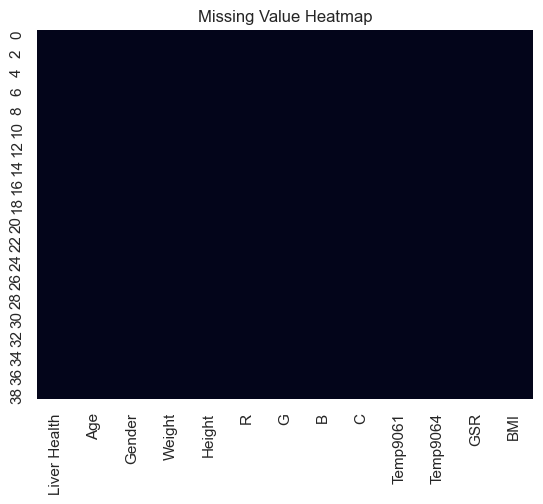

IQR filter retains 31 of 39 rows
Z-score filter retains 38 of 39 rows


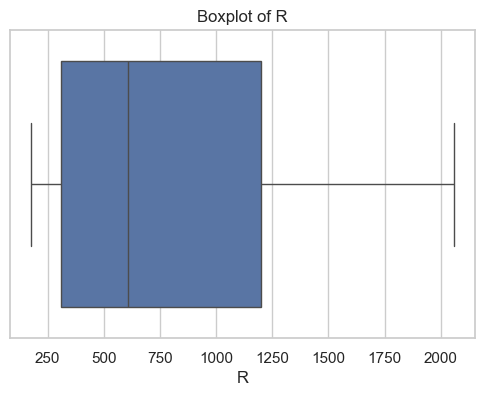

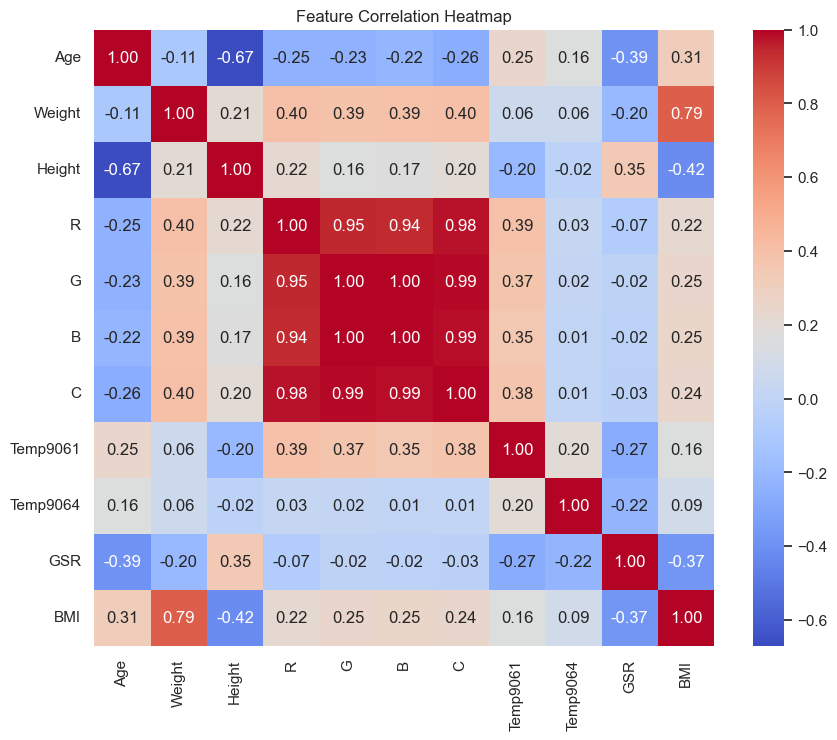

=== RandomForest Feature Importances ===
GSR         0.293241
BMI         0.123441
Temp9064    0.088899
Height      0.084534
Weight      0.079250
R           0.063228
Temp9061    0.059689
Age         0.056010
G           0.050659
C           0.050616
B           0.050434
dtype: float64

=== Permutation Importances ===
GSR         0.264103
Height      0.007692
Temp9064    0.005128
Temp9061    0.002564
Age         0.000000
Weight      0.000000
R           0.000000
G           0.000000
B           0.000000
C           0.000000
BMI         0.000000
dtype: float64


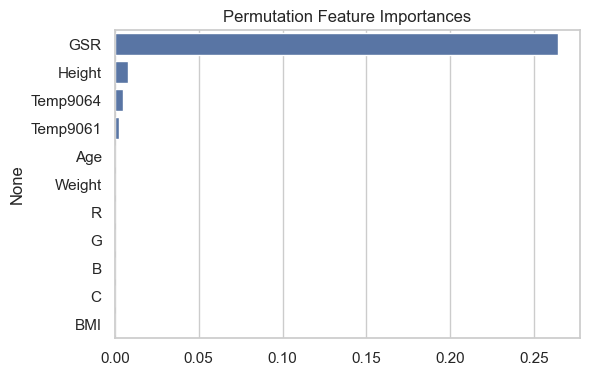

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import LabelEncoder

# — 0. Load the aggregated data
df = pd.read_csv("aggregated.csv")

# — 1. Summary Statistics
print("=== Summary Statistics ===")
print(df.describe())

# — 2. Missing Value Analysis
print("\n=== Missing Values ===")
print(df.isnull().sum())
print((df.isnull().mean() * 100).round(2), "% missing per column")

# Optional: visualize missingness
sns.heatmap(df.isnull(), cbar=False)
plt.title("Missing Value Heatmap")
plt.show()

# — 3. Outlier Detection
num_cols = df.select_dtypes(include=[np.number]).columns
# 3a. IQR method
Q1 = df[num_cols].quantile(0.25)
Q3 = df[num_cols].quantile(0.75)
IQR = Q3 - Q1
mask_iqr = ~((df[num_cols] < (Q1 - 1.5 * IQR)) | (df[num_cols] > (Q3 + 1.5 * IQR))).any(axis=1)
print(f"IQR filter retains {mask_iqr.sum()} of {len(df)} rows")

# 3b. Z-score method (numeric only)

z_scores = np.abs(stats.zscore(df[num_cols].fillna(df[num_cols].mean())))
mask_z = (z_scores < 3).all(axis=1)
print(f"Z-score filter retains {mask_z.sum()} of {len(df)} rows")

# Boxplot for one feature as example
plt.figure(figsize=(6,4))
sns.boxplot(x=df["R"])
plt.title("Boxplot of R")
plt.show()

# — 4. Correlation Analysis
corr = df[num_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.show()

# — 5. Feature Importance

# 5a. Encode target if categorical
le = LabelEncoder()
df["liver_health_enc"] = le.fit_transform(df["Liver Health"].astype(str))

# 5b. Random Forest Importance
X = df[num_cols]
y = df["liver_health_enc"]
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X.fillna(X.mean()), y)
imp = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
print("=== RandomForest Feature Importances ===")
print(imp)

# 5c. Permutation Importance
perm = permutation_importance(rf, X.fillna(X.mean()), y, n_repeats=10, random_state=42)
perm_imp = pd.Series(perm.importances_mean, index=X.columns).sort_values(ascending=False)
print("\n=== Permutation Importances ===")
print(perm_imp)

# Visualize importances
plt.figure(figsize=(6,4))
sns.barplot(x=perm_imp.values, y=perm_imp.index)
plt.title("Permutation Feature Importances")
plt.show()


In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['liver_health_code'] = le.fit_transform(df['Liver Health'])


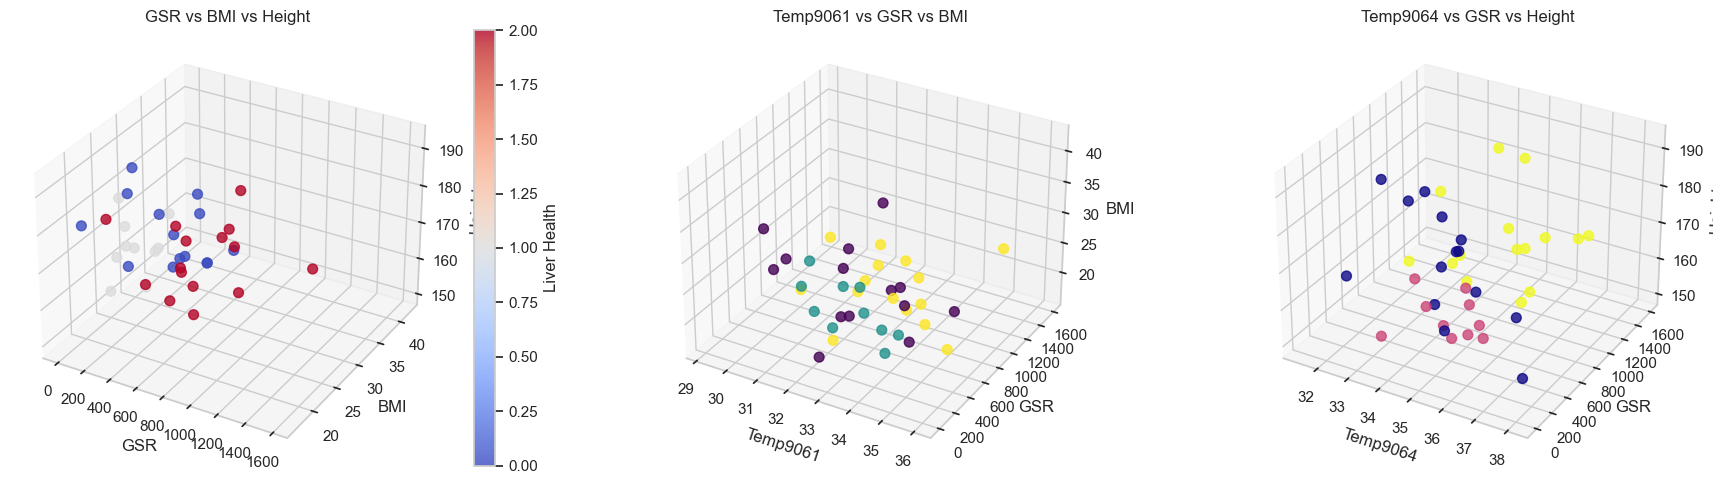

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Apply seaborn theme
sns.set_theme(style="whitegrid")  # or sns.set_style("ticks") :contentReference[oaicite:2]{index=2}

# Assuming df is your cleaned DataFrame and 'liver_health' is encoded 0/1
fig = plt.figure(figsize=(18, 5))

# --- 3D scatter for GSR, BMI, Height ---
ax1 = fig.add_subplot(131, projection='3d')
p1 = ax1.scatter(
    df['GSR'], df['BMI'], df['Height'],
    c=df['liver_health_enc'], cmap='coolwarm', s=50, alpha=0.8
)
ax1.set_xlabel('GSR')
ax1.set_ylabel('BMI')
ax1.set_zlabel('Height')
ax1.set_title('GSR vs BMI vs Height')
plt.colorbar(p1, ax=ax1, label='Liver Health')  # add colorbar :contentReference[oaicite:3]{index=3}

# --- 3D scatter for Temp9061, GSR, BMI ---
ax2 = fig.add_subplot(132, projection='3d')
p2 = ax2.scatter(
    df['Temp9061'], df['GSR'], df['BMI'],
    c=df['liver_health_enc'], cmap='viridis', s=50, alpha=0.8
)
ax2.set_xlabel('Temp9061')
ax2.set_ylabel('GSR')
ax2.set_zlabel('BMI')
ax2.set_title('Temp9061 vs GSR vs BMI')

# --- 3D scatter for Temp9064, GSR, Height ---
ax3 = fig.add_subplot(133, projection='3d')
p3 = ax3.scatter(
    df['Temp9064'], df['GSR'], df['Height'],
    c=df['liver_health_enc'], cmap='plasma', s=50, alpha=0.8
)
ax3.set_xlabel('Temp9064')
ax3.set_ylabel('GSR')
ax3.set_zlabel('Height')
ax3.set_title('Temp9064 vs GSR vs Height')

plt.tight_layout()
plt.show()


In [ ]:
df.head()

,Liver Health,Age,Gender,Weight,Height,R,G,B,C,Temp9061,Temp9064,GSR,BMI,liver_health
0,Yes,20,Male,60.0,172.0,585.00,385.17,259.67,1223.83,31.76,37.22,1151.17,20.28,2
1,Yes,20,Male,80.0,175.0,569.67,333.67,211.17,1099.00,30.76,35.57,914.83,26.12,2
2,Mid,21,Male,93.0,175.0,817.14,501.29,317.29,1617.71,29.65,35.01,500.57,30.37,0
3,Yes,19,Male,64.0,170.0,1029.00,610.17,376.50,1989.67,32.31,34.64,664.00,22.15,2
4,Mid,20,Male,102.0,177.0,1409.29,845.14,541.14,2762.71,32.68,35.17,404.71,32.56,0


In [19]:
df.head()

,Liver Health,Age,Gender,Weight,Height,R,G,B,C,Temp9061,Temp9064,GSR,BMI
0,Yes,20,Male,60.0,172.0,585.00,385.17,259.67,1223.83,31.76,37.22,1151.17,20.28
1,Yes,20,Male,80.0,175.0,569.67,333.67,211.17,1099.00,30.76,35.57,914.83,26.12
2,Mid,21,Male,93.0,175.0,817.14,501.29,317.29,1617.71,29.65,35.01,500.57,30.37
3,Yes,19,Male,64.0,170.0,1029.00,610.17,376.50,1989.67,32.31,34.64,664.00,22.15
4,Mid,20,Male,102.0,177.0,1409.29,845.14,541.14,2762.71,32.68,35.17,404.71,32.56


In [21]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from collections import Counter
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler

# 1) Load the data
df = pd.read_csv("aggregated.csv")

# # 2) Encode the target in-place
le = LabelEncoder()
df['liver_health'] = le.fit_transform(df['Liver Health'])

# 3) Separate features & target
X = df.drop(columns=['Liver Health', 'liver_health'])
y = df['liver_health']

# 4) One-hot encode any categorical features (here: Gender)
X_enc = pd.get_dummies(X, columns=['Gender'], drop_first=True)

# 5) Check original class distribution
orig_counts = Counter(y)
print("Original class counts:", orig_counts)

# 6a) SMOTE (default k_neighbors=5 is safe if min_count>5)
sm = SMOTE(random_state=42)
X_sm, y_sm = sm.fit_resample(X_enc, y)
print("SMOTE class counts:   ", Counter(y_sm))

# 6b) ADASYN using 'not majority' strategy
#    This will boost every minority class up to the majority size
# ada = ADASYN(
#     sampling_strategy='not majority',
#     n_neighbors=max(1, min(orig_counts.values()) - 1),
#     random_state=42
# )
# X_ad, y_ad = ada.fit_resample(X_enc, y)
# print("ADASYN class counts:  ", Counter(y_ad))

# 6c) Random OverSampler
ros = RandomOverSampler(random_state=42)
X_ros, y_ros = ros.fit_resample(X_enc, y)
print("ROS class counts:     ", Counter(y_ros))

# 7) Wrap back into DataFrames (if you need to inspect or save)
df_sm  = pd.DataFrame(X_sm,  columns=X_enc.columns); df_sm['liver_health'] = y_sm
# df_ad  = pd.DataFrame(X_ad,  columns=X_enc.columns); df_ad['liver_health'] = y_ad
df_ros = pd.DataFrame(X_ros, columns=X_enc.columns); df_ros['liver_health'] = y_ros

# 8) (Optional) Save to CSV for downstream modeling
df_sm.to_csv("oversampled_smote.csv", index=False)
# df_ad.to_csv("oversampled_adasyn.csv", index=False)
df_ros.to_csv("oversampled_ros.csv", index=False)


Original class counts: Counter({2: 15, 0: 14, 1: 10})
SMOTE class counts:    Counter({2: 15, 0: 15, 1: 15})
ROS class counts:      Counter({2: 15, 0: 15, 1: 15})


In [13]:
from collections import Counter
print("Class counts →", Counter(y))


Class counts → Counter({2: 15, 0: 14, 1: 10})


In [17]:
df.head()

,Liver Health,Age,Gender,Weight,Height,R,G,B,C,Temp9061,Temp9064,GSR,BMI,liver_health
0,Yes,20,Male,60.0,172.0,585.00,385.17,259.67,1223.83,31.76,37.22,1151.17,20.28,2
1,Yes,20,Male,80.0,175.0,569.67,333.67,211.17,1099.00,30.76,35.57,914.83,26.12,2
2,Mid,21,Male,93.0,175.0,817.14,501.29,317.29,1617.71,29.65,35.01,500.57,30.37,0
3,Yes,19,Male,64.0,170.0,1029.00,610.17,376.50,1989.67,32.31,34.64,664.00,22.15,2
4,Mid,20,Male,102.0,177.0,1409.29,845.14,541.14,2762.71,32.68,35.17,404.71,32.56,0


In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import LabelEncoder

def eda_analysis(data, target_col='Liver Health'):
    """
    Perform EDA including:
    1. Summary statistics
    2. Missing value analysis
    3. Outlier detection (IQR & Z-score)
    4. Correlation heatmap
    5. Feature importance (RF + permutation)
    
    Parameters:
    - data: pd.DataFrame or path to a CSV file
    - target_col: name of the target column for label encoding
    """
    # Load data if path provided
    if isinstance(data, str):
        df = pd.read_csv(data)
    else:
        df = data.copy()
    
    # 1. Summary Statistics
    print("=== Summary Statistics ===")
    display(df.describe())
    
    # 2. Missing Value Analysis
    print("\n=== Missing Values ===")
    print(df.isnull().sum())
    print((df.isnull().mean() * 100).round(2), "% missing per column")
    plt.figure(figsize=(8,4))
    sns.heatmap(df.isnull(), cbar=False)
    plt.title("Missing Value Heatmap")
    plt.show()
    
    # Identify numeric columns
    num_cols = df.select_dtypes(include=[np.number]).columns
    
    # 3. Outlier Detection
    print("\n=== Outlier Detection ===")
    # IQR method
    Q1 = df[num_cols].quantile(0.25)
    Q3 = df[num_cols].quantile(0.75)
    IQR = Q3 - Q1
    mask_iqr = ~((df[num_cols] < (Q1 - 1.5 * IQR)) | (df[num_cols] > (Q3 + 1.5 * IQR))).any(axis=1)
    print(f"IQR method retains {mask_iqr.sum()} of {len(df)} rows")
    
    # Z-score method
    z_scores = np.abs(stats.zscore(df[num_cols].fillna(df[num_cols].mean())))
    mask_z = (z_scores < 3).all(axis=1)
    print(f"Z-score method retains {mask_z.sum()} of {len(df)} rows")
    
    # Example boxplot
    plt.figure(figsize=(6,4))
    sns.boxplot(x=df[num_cols[0]])
    plt.title(f"Boxplot of {num_cols[0]}")
    plt.show()
    
    # 4. Correlation Analysis
    print("\n=== Correlation Heatmap ===")
    corr = df[num_cols].corr()
    plt.figure(figsize=(10,8))
    sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
    plt.title("Feature Correlation Heatmap")
    plt.show()
    
    # 5. Feature Importance
    print("\n=== Feature Importance ===")
    # Encode target
    le = LabelEncoder()
    df['__target_enc'] = le.fit_transform(df[target_col].astype(str))
    
    X = df[num_cols]
    y = df['__target_enc']
    
    # Random Forest importance
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X.fillna(X.mean()), y)
    imp = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
    print("RandomForest feature importances:")
    display(imp)
    
    # Permutation importance
    perm = permutation_importance(rf, X.fillna(X.mean()), y, n_repeats=10, random_state=42)
    perm_imp = pd.Series(perm.importances_mean, index=X.columns).sort_values(ascending=False)
    print("\nPermutation importances:")
    display(perm_imp)
    
    plt.figure(figsize=(6,4))
    sns.barplot(x=perm_imp.values, y=perm_imp.index)
    plt.title("Permutation Feature Importances")
    plt.show()
    
    # Clean up
    df.drop(columns='__target_enc', inplace=True)


# Example usage:
# eda_analysis("aggregated.csv")
# eda_analysis(df_sm, target_col='liver_health')


=== Summary Statistics ===


,Age,Weight,Height,R,G,B,C,Temp9061,Temp9064,GSR,BMI,liver_health
count,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000
mean,39.155556,74.015239,171.084944,791.806710,475.550371,313.019348,1534.218009,33.081801,35.405634,437.035115,25.424398,1.000000
std,25.384279,12.318737,9.116564,569.542614,331.082986,205.837200,1077.062559,1.573569,1.532956,371.737395,4.810274,0.825723
min,19.000000,53.000000,150.000000,176.330000,100.000000,67.140000,327.000000,29.170000,31.380000,0.000000,16.360000,0.000000
25%,20.000000,64.133571,163.883833,328.200370,200.074997,168.760236,673.978316,32.600000,34.640000,145.500000,21.480000,0.000000
50%,20.000000,74.000000,171.000000,585.000000,353.140000,231.430000,1189.290000,33.090809,35.570000,294.330000,24.930000,1.000000
75%,70.000000,80.000000,178.000000,1213.351938,635.445976,424.838212,2163.073604,33.970000,36.539435,675.000000,28.624455,2.000000
max,85.000000,102.000000,193.000000,2058.830000,1259.000000,797.330000,3968.170000,36.030000,38.130000,1589.140000,42.220000,2.000000



=== Missing Values ===
Age             0
Weight          0
Height          0
R               0
G               0
B               0
C               0
Temp9061        0
Temp9064        0
GSR             0
BMI             0
Gender_Male     0
liver_health    0
dtype: int64
Age             0.0
Weight          0.0
Height          0.0
R               0.0
G               0.0
B               0.0
C               0.0
Temp9061        0.0
Temp9064        0.0
GSR             0.0
BMI             0.0
Gender_Male     0.0
liver_health    0.0
dtype: float64 % missing per column


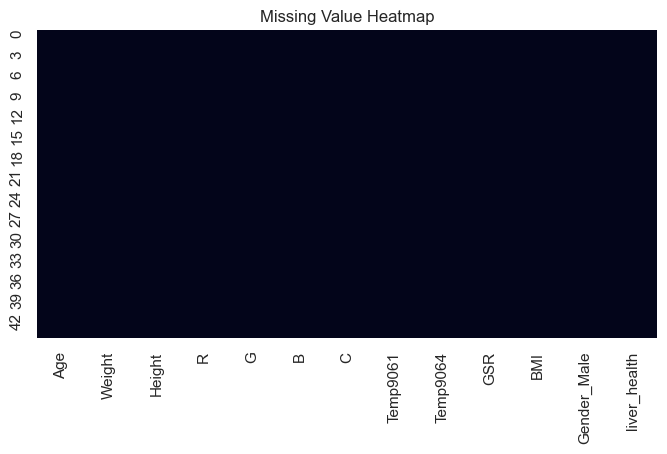


=== Outlier Detection ===
IQR method retains 37 of 45 rows
Z-score method retains 43 of 45 rows


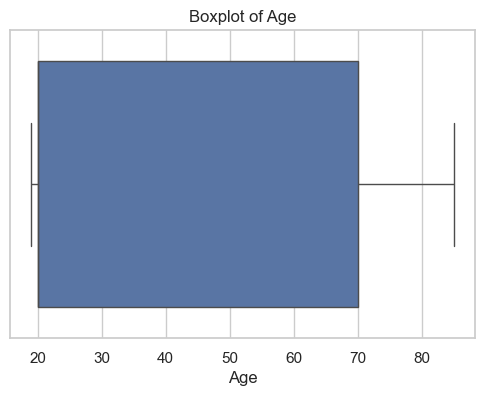


=== Correlation Heatmap ===


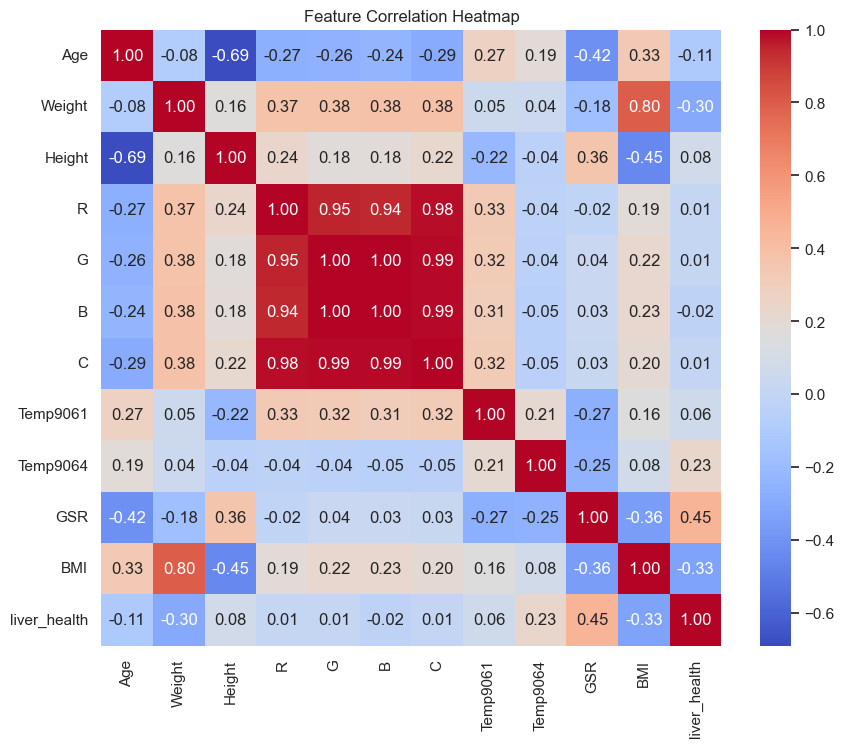


=== Feature Importance ===
RandomForest feature importances:


liver_health    0.332427
GSR             0.204075
BMI             0.087751
Age             0.072165
Temp9064        0.065241
Height          0.055787
Temp9061        0.038405
Weight          0.035722
G               0.033316
B               0.029332
C               0.028017
R               0.017762
dtype: float64


Permutation importances:


liver_health    0.277778
GSR             0.008889
Age             0.000000
Weight          0.000000
Height          0.000000
R               0.000000
G               0.000000
B               0.000000
C               0.000000
Temp9061        0.000000
Temp9064        0.000000
BMI             0.000000
dtype: float64

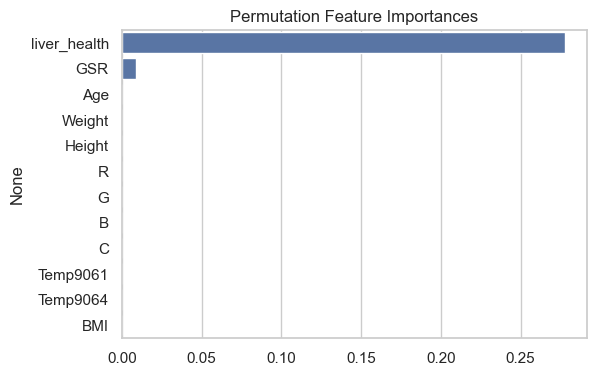

In [24]:
eda_analysis(df_sm, target_col='liver_health')

=== Summary Statistics ===


,Age,Weight,Height,R,G,B,C,Temp9061,Temp9064,GSR,BMI,liver_health
count,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000
mean,39.200000,73.244444,170.866667,838.866667,498.593556,326.265778,1615.836222,33.145333,35.328667,442.236000,25.201556,1.000000
std,25.728124,12.424601,9.687386,594.746696,349.518790,217.148761,1129.479444,1.636777,1.542304,367.009547,4.686831,0.825723
min,19.000000,53.000000,150.000000,176.330000,100.000000,67.140000,327.000000,29.170000,31.380000,0.000000,16.360000,0.000000
25%,20.000000,64.000000,162.000000,337.670000,195.170000,171.670000,654.710000,32.600000,34.640000,146.830000,21.480000,0.000000
50%,20.000000,73.000000,171.000000,608.860000,380.290000,242.860000,1223.830000,33.090000,35.490000,294.330000,24.170000,1.000000
75%,70.000000,80.000000,178.000000,1266.570000,740.290000,468.860000,2405.500000,34.470000,36.500000,675.000000,27.890000,2.000000
max,85.000000,102.000000,193.000000,2058.830000,1259.000000,797.330000,3968.170000,36.030000,38.130000,1589.140000,42.220000,2.000000



=== Missing Values ===
Age             0
Weight          0
Height          0
R               0
G               0
B               0
C               0
Temp9061        0
Temp9064        0
GSR             0
BMI             0
Gender_Male     0
liver_health    0
dtype: int64
Age             0.0
Weight          0.0
Height          0.0
R               0.0
G               0.0
B               0.0
C               0.0
Temp9061        0.0
Temp9064        0.0
GSR             0.0
BMI             0.0
Gender_Male     0.0
liver_health    0.0
dtype: float64 % missing per column


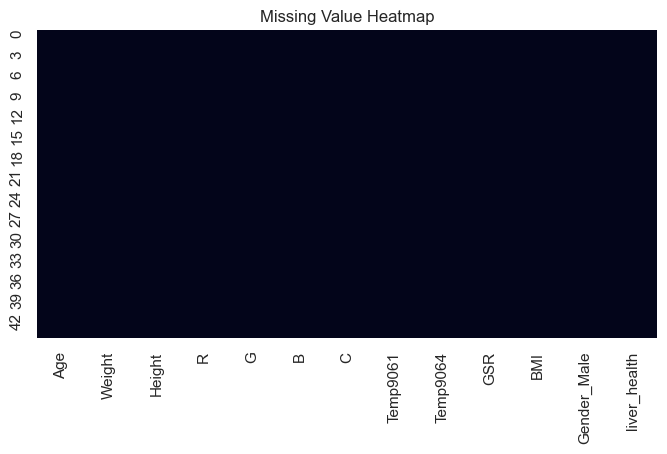


=== Outlier Detection ===
IQR method retains 38 of 45 rows
Z-score method retains 43 of 45 rows


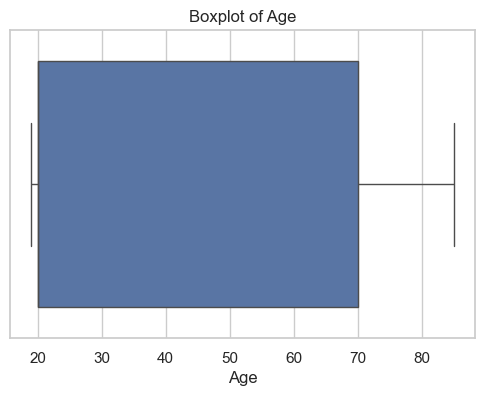


=== Correlation Heatmap ===


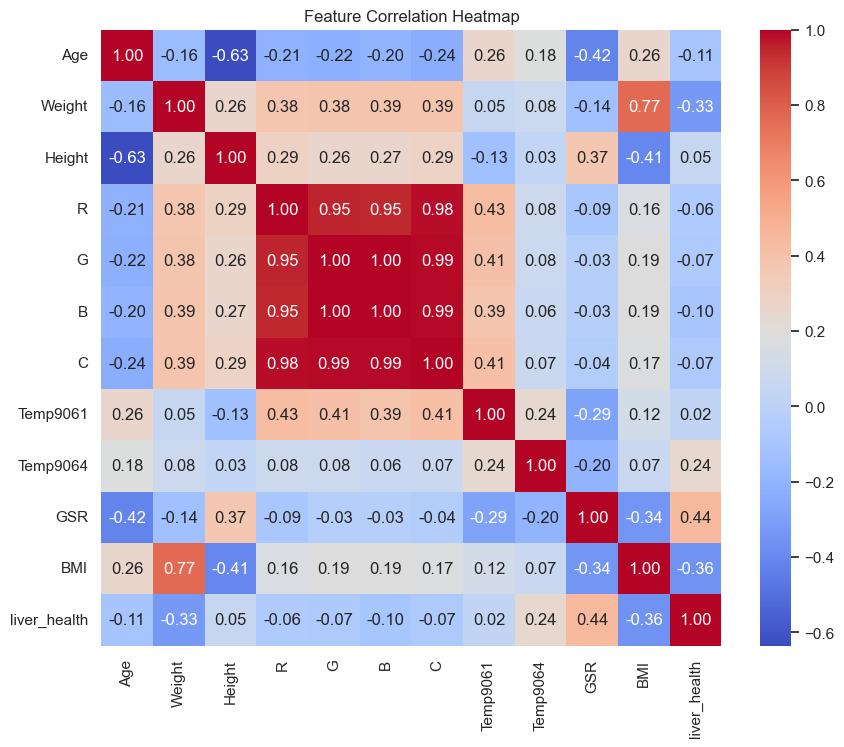


=== Feature Importance ===
RandomForest feature importances:


liver_health    0.345532
GSR             0.209984
BMI             0.082934
Age             0.068407
Height          0.053057
Temp9064        0.046036
Weight          0.038493
Temp9061        0.037818
B               0.032533
G               0.030430
R               0.027920
C               0.026856
dtype: float64


Permutation importances:


liver_health    0.313333
Age             0.000000
Weight          0.000000
Height          0.000000
R               0.000000
G               0.000000
B               0.000000
C               0.000000
Temp9061        0.000000
Temp9064        0.000000
GSR             0.000000
BMI             0.000000
dtype: float64

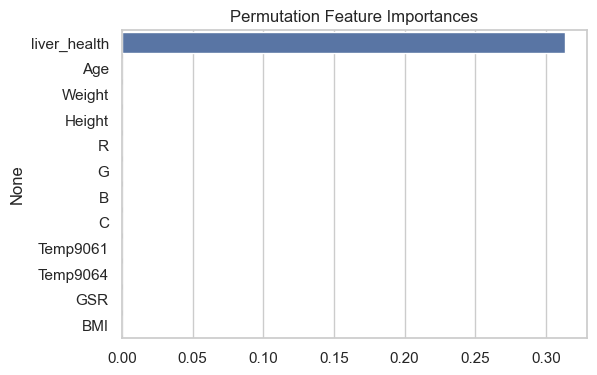

In [25]:
eda_analysis(df_ros, target_col='liver_health')

In [35]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model    import SGDClassifier
from sklearn.ensemble        import RandomForestClassifier
from sklearn.svm             import SVC
from xgboost                 import XGBClassifier
from sklearn.metrics         import accuracy_score, roc_auc_score

# Helper to split once
def train_val_split(X, y, test_size=0.2, random_state=42):
    return train_test_split(
        X, y, test_size=test_size, stratify=y, random_state=random_state
    )

### 1. Logistic Regression via SGDClassifier (per-epoch logging) ###
def train_logistic_sgd(X, y, epochs=50):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_tr, X_val, y_tr, y_val = train_val_split(X_scaled, y)
    clf = SGDClassifier(loss='log_loss', penalty='l2',
                        max_iter=1, tol=None, warm_start=True,
                        random_state=42)
    print("Epoch | Accuracy | ROC-AUC")
    for epoch in range(1, epochs+1):
        clf.partial_fit(X_tr, y_tr, classes=np.unique(y))
        y_pred  = clf.predict(X_val)
        y_proba = clf.predict_proba(X_val)
        acc = accuracy_score(y_val, y_pred)
        auc = roc_auc_score(y_val, y_proba, multi_class='ovr')
        print(f"{epoch:5d} | {acc:.3f}    | {auc:.3f}")

### 2. Random Forest with warm_start (add trees incrementally) ###
def train_random_forest_warm(X, y, total_trees=200, step=20):
    X_tr, X_val, y_tr, y_val = train_val_split(X, y)
    rf = RandomForestClassifier(warm_start=True, random_state=42)
    print("Trees | Accuracy | ROC-AUC")
    for n in range(step, total_trees+1, step):
        rf.set_params(n_estimators=n)
        rf.fit(X_tr, y_tr)
        y_pred  = rf.predict(X_val)
        y_proba = rf.predict_proba(X_val)
        acc = accuracy_score(y_val, y_pred)
        auc = roc_auc_score(y_val, y_proba, multi_class='ovr')
        print(f"{n:5d} | {acc:.3f}    | {auc:.3f}")

### 3. XGBoost with eval_set (built‐in per‐round logging) ###
def train_xgboost_verbose(X, y, num_rounds=100, early_stop=10):
    """
    Train an XGBClassifier with early stopping and per-round logging.
    Parameters:
      - X, y: feature matrix and encoded target
      - num_rounds: total boosting rounds (n_estimators)
      - early_stop: early_stopping_rounds for the constructor
    Returns:
      - dict of final accuracy, ROC-AUC, recall, precision, and F1.
    """
    # 1) Split once for validation
    X_tr, X_val, y_tr, y_val = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )
    
    # 2) Instantiate the model with early stopping and verbosity
    model = XGBClassifier(
        n_estimators=num_rounds,
        use_label_encoder=False,
        eval_metric='mlogloss',          # set evaluation metric in constructor :contentReference[oaicite:5]{index=5}
        early_stopping_rounds=early_stop, # must go here, not in fit() :contentReference[oaicite:6]{index=6}
        verbosity=1,                     # control output level (0–3) :contentReference[oaicite:7]{index=7}
        random_state=42
    )

    # 3) Fit with only eval_set for validation monitoring
    model.fit(
        X_tr, y_tr,
        eval_set=[(X_val, y_val)]
        # no verbose or early_stopping_rounds here
    )

    # 4) Evaluate on validation set
    y_pred  = model.predict(X_val)
    y_proba = model.predict_proba(X_val)

    return {
        "accuracy" : accuracy_score(y_val, y_pred),
        "roc_auc"  : roc_auc_score(y_val, y_proba, multi_class="ovr"),
        "recall"   : recall_score(y_val, y_pred, average="weighted"),
        "precision": precision_score(y_val, y_pred, average="weighted"),
        "f1_score" : f1_score(y_val, y_pred, average="weighted")
    }
### 4. SVM via SGDClassifier (hinge loss) ###
def train_svm_sgd(X, y, epochs=50):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_tr, X_val, y_tr, y_val = train_val_split(X_scaled, y)
    clf = SGDClassifier(loss='hinge', penalty='l2',
                        max_iter=1, tol=None,
                        warm_start=True, random_state=42)
    print("Epoch | Accuracy")
    for epoch in range(1, epochs+1):
        clf.partial_fit(X_tr, y_tr, classes=np.unique(y))
        y_pred = clf.predict(X_val)
        acc = accuracy_score(y_val, y_pred)
        print(f"{epoch:5d} | {acc:.3f}")


In [27]:
df.head()

,Liver Health,Age,Gender,Weight,Height,R,G,B,C,Temp9061,Temp9064,GSR,BMI,liver_health_enc
0,Yes,20,Male,60.0,172.0,585.00,385.17,259.67,1223.83,31.76,37.22,1151.17,20.28,2
1,Yes,20,Male,80.0,175.0,569.67,333.67,211.17,1099.00,30.76,35.57,914.83,26.12,2
2,Mid,21,Male,93.0,175.0,817.14,501.29,317.29,1617.71,29.65,35.01,500.57,30.37,0
3,Yes,19,Male,64.0,170.0,1029.00,610.17,376.50,1989.67,32.31,34.64,664.00,22.15,2
4,Mid,20,Male,102.0,177.0,1409.29,845.14,541.14,2762.71,32.68,35.17,404.71,32.56,0


In [28]:
df_ros.head()

,Age,Weight,Height,R,G,B,C,Temp9061,Temp9064,GSR,BMI,Gender_Male,liver_health
0,20,60.0,172.0,585.00,385.17,259.67,1223.83,31.76,37.22,1151.17,20.28,True,2
1,20,80.0,175.0,569.67,333.67,211.17,1099.00,30.76,35.57,914.83,26.12,True,2
2,21,93.0,175.0,817.14,501.29,317.29,1617.71,29.65,35.01,500.57,30.37,True,0
3,19,64.0,170.0,1029.00,610.17,376.50,1989.67,32.31,34.64,664.00,22.15,True,2
4,20,102.0,177.0,1409.29,845.14,541.14,2762.71,32.68,35.17,404.71,32.56,True,0


In [29]:
df_sm.head()

,Age,Weight,Height,R,G,B,C,Temp9061,Temp9064,GSR,BMI,Gender_Male,liver_health
0,20,60.0,172.0,585.00,385.17,259.67,1223.83,31.76,37.22,1151.17,20.28,True,2
1,20,80.0,175.0,569.67,333.67,211.17,1099.00,30.76,35.57,914.83,26.12,True,2
2,21,93.0,175.0,817.14,501.29,317.29,1617.71,29.65,35.01,500.57,30.37,True,0
3,19,64.0,170.0,1029.00,610.17,376.50,1989.67,32.31,34.64,664.00,22.15,True,2
4,20,102.0,177.0,1409.29,845.14,541.14,2762.71,32.68,35.17,404.71,32.56,True,0


In [40]:
train_logistic_sgd(X, y, epochs=30)


Epoch | Accuracy | ROC-AUC
    1 | 0.375    | 0.683
    2 | 0.500    | 0.728
    3 | 0.500    | 0.761
    4 | 0.375    | 0.667
    5 | 0.375    | 0.622
    6 | 0.375    | 0.567
    7 | 0.500    | 0.650
    8 | 0.375    | 0.617
    9 | 0.375    | 0.611
   10 | 0.625    | 0.686
   11 | 0.625    | 0.694
   12 | 0.500    | 0.622
   13 | 0.500    | 0.639
   14 | 0.500    | 0.594
   15 | 0.625    | 0.664
   16 | 0.500    | 0.686
   17 | 0.500    | 0.747
   18 | 0.625    | 0.761
   19 | 0.625    | 0.783
   20 | 0.625    | 0.731
   21 | 0.625    | 0.681
   22 | 0.625    | 0.725
   23 | 0.375    | 0.589
   24 | 0.625    | 0.611
   25 | 0.500    | 0.661
   26 | 0.500    | 0.658
   27 | 0.625    | 0.775
   28 | 0.625    | 0.686
   29 | 0.625    | 0.664
   30 | 0.625    | 0.789


In [38]:
train_xgboost_verbose(X, y, num_rounds=100, early_stop=10)

[0]	validation_0-mlogloss:1.00002
[1]	validation_0-mlogloss:0.92156
[2]	validation_0-mlogloss:0.87357
[3]	validation_0-mlogloss:0.83800
[4]	validation_0-mlogloss:0.81920
[5]	validation_0-mlogloss:0.81744
[6]	validation_0-mlogloss:0.81450
[7]	validation_0-mlogloss:0.80056
[8]	validation_0-mlogloss:0.81802
[9]	validation_0-mlogloss:0.84311
[10]	validation_0-mlogloss:0.86036
[11]	validation_0-mlogloss:0.88235
[12]	validation_0-mlogloss:0.89201
[13]	validation_0-mlogloss:0.91450
[14]	validation_0-mlogloss:0.92587
[15]	validation_0-mlogloss:0.91102
[16]	validation_0-mlogloss:0.92003
[17]	validation_0-mlogloss:0.91908


c:\Users\Mohit Bagga\anaconda3\envs\atlas\lib\site-packages\xgboost\callback.py:386: UserWarning: [12:40:36] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


{'accuracy': 0.625,
 'roc_auc': 0.8166666666666668,
 'recall': 0.625,
 'precision': 0.6041666666666666,
 'f1_score': 0.6000000000000001}

In [39]:
train_svm_sgd(X, y, epochs=30)

Epoch | Accuracy
    1 | 0.250
    2 | 0.500
    3 | 0.500
    4 | 0.500
    5 | 0.625
    6 | 0.500
    7 | 0.500
    8 | 0.500
    9 | 0.625
   10 | 0.500
   11 | 0.500
   12 | 0.625
   13 | 0.625
   14 | 0.500
   15 | 0.500
   16 | 0.500
   17 | 0.500
   18 | 0.375
   19 | 0.625
   20 | 0.500
   21 | 0.500
   22 | 0.625
   23 | 0.625
   24 | 0.625
   25 | 0.500
   26 | 0.625
   27 | 0.500
   28 | 0.500
   29 | 0.625
   30 | 0.625


In [41]:
train_random_forest_warm(X,y)

Trees | Accuracy | ROC-AUC
   20 | 0.375    | 0.611
   40 | 0.375    | 0.747
   60 | 0.625    | 0.783
   80 | 0.625    | 0.783
  100 | 0.750    | 0.783
  120 | 0.625    | 0.789
  140 | 0.750    | 0.783
  160 | 0.625    | 0.783
  180 | 0.750    | 0.806
  200 | 0.625    | 0.806


In [42]:
import pandas as pd
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model    import LogisticRegression
from sklearn.ensemble        import RandomForestClassifier
from sklearn.svm             import SVC
from xgboost                 import XGBClassifier
from sklearn.metrics         import make_scorer, accuracy_score, roc_auc_score

def tune_model(estimator, param_grid, X, y, cv=5, scoring='accuracy'):
    """
    Run GridSearchCV and return best params and score.
    """
    grid = GridSearchCV(
        estimator=estimator,
        param_grid=param_grid,
        cv=cv,
        scoring=scoring,
        n_jobs=-1,
        verbose=1
    )
    grid.fit(X, y)
    return grid.best_params_, grid.best_score_

# # --- Load & prepare data ---
# df = pd.read_csv("aggregated.csv")
# df['liver_health_enc'] = pd.factorize(df['Liver Health'])[0]
X = df.drop(columns=['Liver Health','liver_health_enc', "Gender"])
y = df['liver_health_enc']

# --- Define grids ---
grids = {
    "LogisticRegression": (
        LogisticRegression(solver='liblinear', max_iter=1000, random_state=42),
        {
            'C': [0.01, 0.1, 1, 10, 100],
            'penalty': ['l1', 'l2']
        }
    ),
    "RandomForest": (
        RandomForestClassifier(random_state=42),
        {
            'n_estimators': [50, 100, 200],
            'max_depth': [None, 5, 10],
            'min_samples_split': [2, 5],
            'max_features': ['sqrt', 'log2']
        }
    ),
    "XGBoost": (
        XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
        {
            'learning_rate': [0.01, 0.1],
            'n_estimators': [50, 100],
            'max_depth': [3, 5, 7],
            'subsample': [0.6, 0.8, 1.0],
            'colsample_bytree': [0.6, 0.8, 1.0]
        }
    ),
    "SVM": (
        SVC(probability=True, random_state=42),
        {
            'C': [0.1, 1, 10, 100],
            'gamma': ['scale', 'auto'],
            'kernel': ['rbf']
        }
    )
}

# --- Run tuning ---
results = {}
for name, (est, grid) in grids.items():
    print(f"\nTuning {name}...")
    best_params, best_score = tune_model(est, grid, X, y, cv=5, scoring='accuracy')
    results[name] = {'best_params': best_params, 'cv_accuracy': best_score}

# --- Display results ---
for model, res in results.items():
    print(f"\n{model}:\n  Best Params: {res['best_params']}\n  CV Accuracy: {res['cv_accuracy']:.3f}")



Tuning LogisticRegression...
Fitting 5 folds for each of 10 candidates, totalling 50 fits

Tuning RandomForest...
Fitting 5 folds for each of 36 candidates, totalling 180 fits

Tuning XGBoost...
Fitting 5 folds for each of 108 candidates, totalling 540 fits


c:\Users\Mohit Bagga\anaconda3\envs\atlas\lib\site-packages\xgboost\training.py:183: UserWarning: [12:49:09] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Tuning SVM...
Fitting 5 folds for each of 8 candidates, totalling 40 fits

LogisticRegression:
  Best Params: {'C': 0.1, 'penalty': 'l1'}
  CV Accuracy: 0.643

RandomForest:
  Best Params: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 50}
  CV Accuracy: 0.750

XGBoost:
  Best Params: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}
  CV Accuracy: 0.775

SVM:
  Best Params: {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}
  CV Accuracy: 0.643


In [43]:
import pandas as pd
import numpy as np

# ────────────────────────────────────────────────────────────────
# 0  Load & initial prep
# ────────────────────────────────────────────────────────────────
df = pd.read_csv("aggregated.csv")
df["liver_health_enc"] = pd.factorize(df["Liver Health"])[0]

# ────────────────────────────────────────────────────────────────
# 1  Feature engineering
#    • Collapse R,G,B,C → first PCA component
# ────────────────────────────────────────────────────────────────
from sklearn.decomposition import PCA
rgbc = df[["R","G","B","C"]].fillna(df[["R","G","B","C"]].mean())
pca  = PCA(n_components=1, random_state=42)
df["rgbc_pca1"] = pca.fit_transform(rgbc)

# Drop original channels
df = df.drop(columns=["R","G","B","C"])

# ────────────────────────────────────────────────────────────────
# 2  Build feature matrix X and target y
# ────────────────────────────────────────────────────────────────
X = pd.get_dummies(
        df.drop(columns=["Liver Health","liver_health_enc"]),
        columns=["Gender"],
        drop_first=True      # creates Gender_Male dummy
    )
y = df["liver_health_enc"]

# ────────────────────────────────────────────────────────────────
# 3  Preprocess pipeline: scale numeric only
# ────────────────────────────────────────────────────────────────
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
pre = ColumnTransformer(
        transformers=[
            ("num", StandardScaler(), num_cols)
        ],
        remainder="passthrough"
    )

# ────────────────────────────────────────────────────────────────
# 4  Define tuned base learners (add class_weight, calibration)
# ────────────────────────────────────────────────────────────────
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble     import RandomForestClassifier
from sklearn.svm          import SVC
from xgboost              import XGBClassifier
from sklearn.calibration  import CalibratedClassifierCV

lr  = LogisticRegression(
        C=0.1, penalty="l1", solver="liblinear",
        class_weight="balanced", max_iter=1000, random_state=42
      )

rf_raw = RandomForestClassifier(
        n_estimators=50, max_features="sqrt",
        class_weight="balanced", random_state=42
      )
rf  = CalibratedClassifierCV(rf_raw, method="isotonic", cv=3)

xgb_raw = XGBClassifier(
        learning_rate=0.1, max_depth=3, n_estimators=50,
        subsample=0.8, colsample_bytree=1.0,
        objective="multi:softprob", eval_metric="mlogloss",
        random_state=42
      )
xgb = CalibratedClassifierCV(xgb_raw, method="isotonic", cv=3)

svm = SVC(
        kernel="rbf", C=100, gamma="scale",
        probability=True, class_weight="balanced",
        random_state=42
      )

# ────────────────────────────────────────────────────────────────
# 5  Build pipelines for each model
# ────────────────────────────────────────────────────────────────
from sklearn.pipeline import Pipeline

pipe_lr  = Pipeline([("pre", pre), ("clf", lr )])
pipe_rf  = Pipeline([("pre", pre), ("clf", rf )])
pipe_xgb = Pipeline([("pre", pre), ("clf", xgb)])
pipe_svm = Pipeline([("pre", pre), ("clf", svm)])

# ────────────────────────────────────────────────────────────────
# 6  Soft-Voting & Stacking ensembles
# ────────────────────────────────────────────────────────────────
from sklearn.ensemble   import VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression as LR_meta

voting = VotingClassifier(
            estimators=[("lr", pipe_lr), ("rf", pipe_rf), ("xgb", pipe_xgb)],
            voting="soft",
            weights=[0.64, 0.75, 0.78]
        )

stack = StackingClassifier(
            estimators=[("lr", pipe_lr), ("rf", pipe_rf), ("xgb", pipe_xgb)],
            final_estimator=LR_meta(max_iter=1000),
            cv=5,
            passthrough=False
        )

# ────────────────────────────────────────────────────────────────
# 7  Robust evaluation
# ────────────────────────────────────────────────────────────────
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score

rkf = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)

for name, mdl in [("Voting", voting), ("Stacking", stack)]:
    acc = cross_val_score(mdl, X, y, cv=rkf, scoring="accuracy")
    auc = cross_val_score(mdl, X, y, cv=rkf, scoring="roc_auc_ovr")
    print(f"\n{name} ensemble")
    print(f"  Accuracy mean±sd : {acc.mean():.3f} ± {acc.std():.3f}")
    print(f"  ROC-AUC  mean±sd : {auc.mean():.3f} ± {auc.std():.3f}")



Voting ensemble
  Accuracy mean±sd : 0.719 ± 0.137
  ROC-AUC  mean±sd : 0.867 ± 0.082

Stacking ensemble
  Accuracy mean±sd : 0.694 ± 0.145
  ROC-AUC  mean±sd : 0.868 ± 0.060


In [63]:
# train_and_save_voting.py
import pandas as pd
import numpy as np
from joblib import dump

# ── 1. load data ───────────────────────────────────────────────
df = pd.read_csv("aggregated.csv")
df["liver_health_enc"] = pd.factorize(df["Liver Health"])[0]

# ── 2. PCA on R-G-B-C  → 1 component ───────────────────────────
from sklearn.decomposition import PCA
rgbc = df[["R", "G", "B", "C"]].fillna(df[["R","G","B","C"]].mean())
df["rgbc_pca1"] = PCA(n_components=1, random_state=42).fit_transform(rgbc)
df = df.drop(columns=["R", "G", "B", "C"])

# ── 3. build X / y and preprocessing transformer ───────────────
X = pd.get_dummies(
        df.drop(columns=["Liver Health", "liver_health_enc"]),
        columns=["Gender"],
        drop_first=True
    )
y = df["liver_health_enc"]

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
pre = ColumnTransformer(
        [("num", StandardScaler(), num_cols)],
        remainder="passthrough"
     )

# ── 4. tuned base learners with calibration & class-weights ────
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble     import RandomForestClassifier, VotingClassifier
from sklearn.calibration  import CalibratedClassifierCV
from xgboost              import XGBClassifier
from sklearn.pipeline     import Pipeline

lr  = LogisticRegression(C=0.1, penalty="l1", solver="liblinear",
                         class_weight="balanced",
                         max_iter=1000, random_state=42)

rf  = CalibratedClassifierCV(
        RandomForestClassifier(n_estimators=50,
                               max_features="sqrt",
                               class_weight="balanced",
                               random_state=42),
        method="isotonic", cv=3)

xgb = CalibratedClassifierCV(
        XGBClassifier(learning_rate=0.1, max_depth=3, n_estimators=50,
                      subsample=0.8, colsample_bytree=1.0,
                      objective="multi:softprob", eval_metric="mlogloss",
                      random_state=42),
        method="isotonic", cv=3)

pipe_lr  = Pipeline([("pre", pre), ("clf", lr )])
pipe_rf  = Pipeline([("pre", pre), ("clf", rf )])
pipe_xgb = Pipeline([("pre", pre), ("clf", xgb)])

voting = VotingClassifier(
            estimators=[("lr", pipe_lr),
                        ("rf", pipe_rf),
                        ("xgb", pipe_xgb)],
            voting="soft",
            weights=[0.64, 0.75, 0.78]   # from CV AUCs
         )

# ── 5. fit on full data & save ─────────────────────────────────
voting.fit(X, y)
dump(voting, "model.pkl")          # → model.pkl in same directory
print("✅  Voting ensemble saved to model.pkl")


✅  Voting ensemble saved to model.pkl


In [58]:
import pandas as pd
import numpy as np

# ────────────────────────────────────────────────────────────────
# 0  Load & initial prep
# ────────────────────────────────────────────────────────────────
# df = pd.read_csv("aggregated.csv")
# df["liver_health_enc"] = pd.factorize(df["Liver Health"])[0]

# ────────────────────────────────────────────────────────────────
# 1  Feature engineering
#    • Collapse R,G,B,C → first PCA component
# ────────────────────────────────────────────────────────────────
from sklearn.decomposition import PCA
# rgbc = df_ros[["R","G","B","C"]].fillna(df_ros[["R","G","B","C"]].mean())
# pca  = PCA(n_components=1, random_state=42)
# df_ros["rgbc_pca1"] = pca.fit_transform(rgbc)

# Drop original channels
# df_ros = df_ros.drop(columns=["R","G","B","C"])

# ────────────────────────────────────────────────────────────────
# 2  Build feature matrix X and target y
# ────────────────────────────────────────────────────────────────
# X = pd.get_dummies(
#         df_ros,
#         columns=["Gender"],
#         drop_first=True      # creates Gender_Male dummy
#     )
# y = df_ros["liver_health"]

# ────────────────────────────────────────────────────────────────
# 3  Preprocess pipeline: scale numeric only
# ────────────────────────────────────────────────────────────────
X = df_ros.drop(columns = ["liver_health"])
y = df_ros["liver_health"]

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
pre = ColumnTransformer(
        transformers=[
            ("num", StandardScaler(), num_cols)
        ],
        remainder="passthrough"
    )


# ────────────────────────────────────────────────────────────────
# 4  Define tuned base learners (add class_weight, calibration)
# ────────────────────────────────────────────────────────────────
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble     import RandomForestClassifier
from sklearn.svm          import SVC
from xgboost              import XGBClassifier
from sklearn.calibration  import CalibratedClassifierCV

lr  = LogisticRegression(
        C=0.1, penalty="l1", solver="liblinear",
        class_weight="balanced", max_iter=1000, random_state=42
      )

rf_raw = RandomForestClassifier(
        n_estimators=50, max_features="sqrt",
        class_weight="balanced", random_state=42
      )
rf  = CalibratedClassifierCV(rf_raw, method="isotonic", cv=3)

xgb_raw = XGBClassifier(
        learning_rate=0.1, max_depth=3, n_estimators=50,
        subsample=0.8, colsample_bytree=1.0,
        objective="multi:softprob", eval_metric="mlogloss",
        random_state=42
      )
xgb = CalibratedClassifierCV(xgb_raw, method="isotonic", cv=3)

svm = SVC(
        kernel="rbf", C=100, gamma="scale",
        probability=True, class_weight="balanced",
        random_state=42
      )

# ────────────────────────────────────────────────────────────────
# 5  Build pipelines for each model
# ────────────────────────────────────────────────────────────────
from sklearn.pipeline import Pipeline

pipe_lr  = Pipeline([("pre", pre), ("clf", lr )])
pipe_rf  = Pipeline([("pre", pre), ("clf", rf )])
pipe_xgb = Pipeline([("pre", pre), ("clf", xgb)])
pipe_svm = Pipeline([("pre", pre), ("clf", svm)])

# ────────────────────────────────────────────────────────────────
# 6  Soft-Voting & Stacking ensembles
# ────────────────────────────────────────────────────────────────
from sklearn.ensemble   import VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression as LR_meta

voting = VotingClassifier(
            estimators=[("lr", pipe_lr), ("rf", pipe_rf), ("xgb", pipe_xgb)],
            voting="soft",
            weights=[0.64, 0.75, 0.78]
        )

stack = StackingClassifier(
            estimators=[("lr", pipe_lr), ("rf", pipe_rf), ("xgb", pipe_xgb)],
            final_estimator=LR_meta(max_iter=1000),
            cv=5,
            passthrough=False
        )

# ────────────────────────────────────────────────────────────────
# 7  Robust evaluation
# ────────────────────────────────────────────────────────────────
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score

rkf = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)

for name, mdl in [("Voting", voting), ("Stacking", stack)]:
    acc = cross_val_score(mdl, X, y, cv=rkf, scoring="accuracy")
    auc = cross_val_score(mdl, X, y, cv=rkf, scoring="roc_auc_ovr")
    print(f"\n{name} ensemble")
    print(f"  Accuracy mean±sd : {acc.mean():.3f} ± {acc.std():.3f}")
    print(f"  ROC-AUC  mean±sd : {auc.mean():.3f} ± {auc.std():.3f}")



Voting ensemble
  Accuracy mean±sd : 0.793 ± 0.114
  ROC-AUC  mean±sd : 0.904 ± 0.081

Stacking ensemble
  Accuracy mean±sd : 0.800 ± 0.116
  ROC-AUC  mean±sd : 0.915 ± 0.069


In [59]:
import pandas as pd
import numpy as np

# ────────────────────────────────────────────────────────────────
# 0  Load & initial prep
# ────────────────────────────────────────────────────────────────
# df = pd.read_csv("aggregated.csv")
# df["liver_health_enc"] = pd.factorize(df["Liver Health"])[0]

# ────────────────────────────────────────────────────────────────
# 1  Feature engineering
#    • Collapse R,G,B,C → first PCA component
# ────────────────────────────────────────────────────────────────
from sklearn.decomposition import PCA
# rgbc = df_ros[["R","G","B","C"]].fillna(df_ros[["R","G","B","C"]].mean())
# pca  = PCA(n_components=1, random_state=42)
# df_ros["rgbc_pca1"] = pca.fit_transform(rgbc)

# Drop original channels
# df_ros = df_ros.drop(columns=["R","G","B","C"])

# ────────────────────────────────────────────────────────────────
# 2  Build feature matrix X and target y
# ────────────────────────────────────────────────────────────────
# X = pd.get_dummies(
#         df_ros,
#         columns=["Gender"],
#         drop_first=True      # creates Gender_Male dummy
#     )
# y = df_ros["liver_health"]

# ────────────────────────────────────────────────────────────────
# 3  Preprocess pipeline: scale numeric only
# ────────────────────────────────────────────────────────────────
X = df_sm.drop(columns = ["liver_health"])
y = df_sm["liver_health"]

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
pre = ColumnTransformer(
        transformers=[
            ("num", StandardScaler(), num_cols)
        ],
        remainder="passthrough"
    )


# ────────────────────────────────────────────────────────────────
# 4  Define tuned base learners (add class_weight, calibration)
# ────────────────────────────────────────────────────────────────
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble     import RandomForestClassifier
from sklearn.svm          import SVC
from xgboost              import XGBClassifier
from sklearn.calibration  import CalibratedClassifierCV

lr  = LogisticRegression(
        C=0.1, penalty="l1", solver="liblinear",
        class_weight="balanced", max_iter=1000, random_state=42
      )

rf_raw = RandomForestClassifier(
        n_estimators=50, max_features="sqrt",
        class_weight="balanced", random_state=42
      )
rf  = CalibratedClassifierCV(rf_raw, method="isotonic", cv=3)

xgb_raw = XGBClassifier(
        learning_rate=0.1, max_depth=3, n_estimators=50,
        subsample=0.8, colsample_bytree=1.0,
        objective="multi:softprob", eval_metric="mlogloss",
        random_state=42
      )
xgb = CalibratedClassifierCV(xgb_raw, method="isotonic", cv=3)

svm = SVC(
        kernel="rbf", C=100, gamma="scale",
        probability=True, class_weight="balanced",
        random_state=42
      )

# ────────────────────────────────────────────────────────────────
# 5  Build pipelines for each model
# ────────────────────────────────────────────────────────────────
from sklearn.pipeline import Pipeline

pipe_lr  = Pipeline([("pre", pre), ("clf", lr )])
pipe_rf  = Pipeline([("pre", pre), ("clf", rf )])
pipe_xgb = Pipeline([("pre", pre), ("clf", xgb)])
pipe_svm = Pipeline([("pre", pre), ("clf", svm)])

# ────────────────────────────────────────────────────────────────
# 6  Soft-Voting & Stacking ensembles
# ────────────────────────────────────────────────────────────────
from sklearn.ensemble   import VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression as LR_meta

voting = VotingClassifier(
            estimators=[("lr", pipe_lr), ("rf", pipe_rf), ("xgb", pipe_xgb)],
            voting="soft",
            weights=[0.64, 0.75, 0.78]
        )

stack = StackingClassifier(
            estimators=[("lr", pipe_lr), ("rf", pipe_rf), ("xgb", pipe_xgb)],
            final_estimator=LR_meta(max_iter=1000),
            cv=5,
            passthrough=False
        )

# ────────────────────────────────────────────────────────────────
# 7  Robust evaluation
# ────────────────────────────────────────────────────────────────
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score

rkf = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)

for name, mdl in [("Voting", voting), ("Stacking", stack)]:
    acc = cross_val_score(mdl, X, y, cv=rkf, scoring="accuracy")
    auc = cross_val_score(mdl, X, y, cv=rkf, scoring="roc_auc_ovr")
    print(f"\n{name} ensemble")
    print(f"  Accuracy mean±sd : {acc.mean():.3f} ± {acc.std():.3f}")
    print(f"  ROC-AUC  mean±sd : {auc.mean():.3f} ± {auc.std():.3f}")



Voting ensemble
  Accuracy mean±sd : 0.770 ± 0.103
  ROC-AUC  mean±sd : 0.904 ± 0.056

Stacking ensemble
  Accuracy mean±sd : 0.770 ± 0.111
  ROC-AUC  mean±sd : 0.917 ± 0.068


In [61]:
# train_and_save_voting.py
import pandas as pd
import numpy as np
from joblib import dump

# ── 1. load data ───────────────────────────────────────────────
# df = pd.read_csv("aggregated.csv")
# df["liver_health_enc"] = pd.factorize(df["Liver Health"])[0]

# ── 2. PCA on R-G-B-C  → 1 component ───────────────────────────
# from sklearn.decomposition import PCA
# rgbc = df[["R", "G", "B", "C"]].fillna(df[["R","G","B","C"]].mean())
# df["rgbc_pca1"] = PCA(n_components=1, random_state=42).fit_transform(rgbc)
# df = df.drop(columns=["R", "G", "B", "C"])

# # ── 3. build X / y and preprocessing transformer ───────────────
# X = pd.get_dummies(
#         df.drop(columns=["Liver Health", "liver_health_enc"]),
#         columns=["Gender"],
#         drop_first=True
#     )
# y = df["liver_health_enc"]
X = df_sm.drop(columns = ["liver_health"])
y = df_sm["liver_health"]

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
pre = ColumnTransformer(
        [("num", StandardScaler(), num_cols)],
        remainder="passthrough"
     )

# ── 4. tuned base learners with calibration & class-weights ────
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble     import RandomForestClassifier, VotingClassifier
from sklearn.calibration  import CalibratedClassifierCV
from xgboost              import XGBClassifier
from sklearn.pipeline     import Pipeline

lr  = LogisticRegression(C=0.1, penalty="l1", solver="liblinear",
                         class_weight="balanced",
                         max_iter=1000, random_state=42)

rf  = CalibratedClassifierCV(
        RandomForestClassifier(n_estimators=50,
                               max_features="sqrt",
                               class_weight="balanced",
                               random_state=42),
        method="isotonic", cv=3)

xgb = CalibratedClassifierCV(
        XGBClassifier(learning_rate=0.1, max_depth=3, n_estimators=50,
                      subsample=0.8, colsample_bytree=1.0,
                      objective="multi:softprob", eval_metric="mlogloss",
                      random_state=42),
        method="isotonic", cv=3)

pipe_lr  = Pipeline([("pre", pre), ("clf", lr )])
pipe_rf  = Pipeline([("pre", pre), ("clf", rf )])
pipe_xgb = Pipeline([("pre", pre), ("clf", xgb)])

voting = VotingClassifier(
            estimators=[("lr", pipe_lr),
                        ("rf", pipe_rf),
                        ("xgb", pipe_xgb)],
            voting="soft",
            weights=[0.64, 0.75, 0.78]   # from CV AUCs
         )

# ── 5. fit on full data & save ─────────────────────────────────
voting.fit(X, y)
dump(voting, "model_sm.pkl")          # → model.pkl in same directory
print("✅  Voting ensemble saved to model.pkl")


✅  Voting ensemble saved to model.pkl


In [62]:
# train_and_save_voting.py
import pandas as pd
import numpy as np
from joblib import dump

# ── 1. load data ───────────────────────────────────────────────
# df = pd.read_csv("aggregated.csv")
# df["liver_health_enc"] = pd.factorize(df["Liver Health"])[0]

# ── 2. PCA on R-G-B-C  → 1 component ───────────────────────────
# from sklearn.decomposition import PCA
# rgbc = df[["R", "G", "B", "C"]].fillna(df[["R","G","B","C"]].mean())
# df["rgbc_pca1"] = PCA(n_components=1, random_state=42).fit_transform(rgbc)
# df = df.drop(columns=["R", "G", "B", "C"])

# # ── 3. build X / y and preprocessing transformer ───────────────
# X = pd.get_dummies(
#         df.drop(columns=["Liver Health", "liver_health_enc"]),
#         columns=["Gender"],
#         drop_first=True
#     )
# y = df["liver_health_enc"]
X = df_ros.drop(columns = ["liver_health"])
y = df_ros["liver_health"]

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
pre = ColumnTransformer(
        [("num", StandardScaler(), num_cols)],
        remainder="passthrough"
     )

# ── 4. tuned base learners with calibration & class-weights ────
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble     import RandomForestClassifier, VotingClassifier
from sklearn.calibration  import CalibratedClassifierCV
from xgboost              import XGBClassifier
from sklearn.pipeline     import Pipeline

lr  = LogisticRegression(C=0.1, penalty="l1", solver="liblinear",
                         class_weight="balanced",
                         max_iter=1000, random_state=42)

rf  = CalibratedClassifierCV(
        RandomForestClassifier(n_estimators=50,
                               max_features="sqrt",
                               class_weight="balanced",
                               random_state=42),
        method="isotonic", cv=3)

xgb = CalibratedClassifierCV(
        XGBClassifier(learning_rate=0.1, max_depth=3, n_estimators=50,
                      subsample=0.8, colsample_bytree=1.0,
                      objective="multi:softprob", eval_metric="mlogloss",
                      random_state=42),
        method="isotonic", cv=3)

pipe_lr  = Pipeline([("pre", pre), ("clf", lr )])
pipe_rf  = Pipeline([("pre", pre), ("clf", rf )])
pipe_xgb = Pipeline([("pre", pre), ("clf", xgb)])

voting = VotingClassifier(
            estimators=[("lr", pipe_lr),
                        ("rf", pipe_rf),
                        ("xgb", pipe_xgb)],
            voting="soft",
            weights=[0.64, 0.75, 0.78]   # from CV AUCs
         )

# ── 5. fit on full data & save ─────────────────────────────────
voting.fit(X, y)
dump(voting, "model_ros.pkl")          # → model.pkl in same directory
print("✅  Voting ensemble saved to model.pkl")


✅  Voting ensemble saved to model.pkl


In [64]:
import pandas as pd, numpy as np
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE

# --- load & prepare --------------------------------------------------
df = pd.read_csv("aggregated.csv")
le = LabelEncoder()
df["liver_health_enc"] = le.fit_transform(df["Liver Health"])
X = pd.get_dummies(df.drop(columns=["Liver Health","liver_health_enc"]),
                   columns=["Gender"], drop_first=True)
y = df["liver_health_enc"]

# --- SMOTE to ~200 rows ---------------------------------------------
target = 67                                # desired rows per class
strategy = {cls: target for cls in np.unique(y)}
smote = SMOTE(sampling_strategy=strategy,
              k_neighbors=5, random_state=42)
X_big, y_big = smote.fit_resample(X, y)

# trim to exactly 200 if needed
if len(y_big) > 200:
    rng = np.random.default_rng(42)
    keep_idx = rng.choice(len(y_big), size=200, replace=False)
    X_big = X_big.iloc[keep_idx]
    y_big = y_big.iloc[keep_idx]

print("Final size:", len(y_big), "rows ->", dict(pd.Series(y_big).value_counts()))
# --------------------------------------------------------------- ready for modelling


Final size: 200 rows -> {0: 67, 2: 67, 1: 66}


In [70]:
y_big

68     0
159    2
186    2
172    2
133    1
      ..
90     0
138    1
99     1
181    2
74     0
Name: liver_health_enc, Length: 200, dtype: int32

In [73]:
import pandas as pd
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model    import LogisticRegression
from sklearn.ensemble        import RandomForestClassifier
from sklearn.svm             import SVC
from xgboost                 import XGBClassifier
from sklearn.metrics         import make_scorer, accuracy_score, roc_auc_score

def tune_model(estimator, param_grid, X, y, cv=5, scoring='accuracy'):
    """
    Run GridSearchCV and return best params and score.
    """
    grid = GridSearchCV(
        estimator=estimator,
        param_grid=param_grid,
        cv=cv,
        scoring=scoring,
        n_jobs=-1,
        verbose=1
    )
    grid.fit(X, y)
    return grid.best_params_, grid.best_score_

# # --- Load & prepare data ---
# df = pd.read_csv("aggregated.csv")
# df['liver_health_enc'] = pd.factorize(df['Liver Health'])[0]
X = X_big
y = y_big

# --- Define grids ---
grids = {
    "LogisticRegression": (
        LogisticRegression(solver='liblinear', max_iter=1000, random_state=42),
        {
            'C': [0.01, 0.1, 1, 10, 100],
            'penalty': ['l1', 'l2']
        }
    ),
    "RandomForest": (
        RandomForestClassifier(random_state=42),
        {
            'n_estimators': [50, 100, 200],
            'max_depth': [None, 5, 10],
            'min_samples_split': [2, 5],
            'max_features': ['sqrt', 'log2']
        }
    ),
    "XGBoost": (
        XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
        {
            'learning_rate': [0.01, 0.1],
            'n_estimators': [50, 100],
            'max_depth': [3, 5, 7],
            'subsample': [0.6, 0.8, 1.0],
            'colsample_bytree': [0.6, 0.8, 1.0]
        }
    ),
    "SVM": (
        SVC(probability=True, random_state=42),
        {
            'C': [0.1, 1, 10, 100],
            'gamma': ['scale', 'auto'],
            'kernel': ['rbf']
        }
    )
}

# --- Run tuning ---
results = {}
for name, (est, grid) in grids.items():
    print(f"\nTuning {name}...")
    best_params, best_score = tune_model(est, grid, X, y, cv=5, scoring='accuracy')
    results[name] = {'best_params': best_params, 'cv_accuracy': best_score}

# --- Display results ---
for model, res in results.items():
    print(f"\n{model}:\n  Best Params: {res['best_params']}\n  CV Accuracy: {res['cv_accuracy']:.3f}")



Tuning LogisticRegression...
Fitting 5 folds for each of 10 candidates, totalling 50 fits

Tuning RandomForest...
Fitting 5 folds for each of 36 candidates, totalling 180 fits

Tuning XGBoost...
Fitting 5 folds for each of 108 candidates, totalling 540 fits


c:\Users\Mohit Bagga\anaconda3\envs\atlas\lib\site-packages\xgboost\training.py:183: UserWarning: [13:53:25] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Tuning SVM...
Fitting 5 folds for each of 8 candidates, totalling 40 fits

LogisticRegression:
  Best Params: {'C': 100, 'penalty': 'l1'}
  CV Accuracy: 0.955

RandomForest:
  Best Params: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 50}
  CV Accuracy: 0.970

XGBoost:
  Best Params: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.6}
  CV Accuracy: 0.975

SVM:
  Best Params: {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}
  CV Accuracy: 0.915


In [ ]:
import pandas as pd
import numpy as np


from sklearn.decomposition import PCA

X = X_big
y = y_big

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
pre = ColumnTransformer(
        transformers=[
            ("num", StandardScaler(), num_cols)
        ],
        remainder="passthrough"
    )


from sklearn.linear_model import LogisticRegression
from sklearn.ensemble     import RandomForestClassifier
from sklearn.svm          import SVC
from xgboost              import XGBClassifier
from sklearn.calibration  import CalibratedClassifierCV

lr  = LogisticRegression(
        C=100, penalty="l1", solver="liblinear",
        class_weight="balanced", max_iter=1000, random_state=42
      )

rf_raw = RandomForestClassifier(
        n_estimators=50, max_features="sqrt",
        class_weight="balanced", random_state=42
      )
rf  = CalibratedClassifierCV(rf_raw, method="isotonic", cv=3)

xgb_raw = XGBClassifier(
        learning_rate=0.1, max_depth=3, n_estimators=50,
        subsample=0.8, colsample_bytree=0.8,
        objective="multi:softprob", eval_metric="mlogloss",
        random_state=42
      )
xgb = CalibratedClassifierCV(xgb_raw, method="isotonic", cv=3)

svm = SVC(
        kernel="rbf", C=100, gamma="scale",
        probability=True, class_weight="balanced",
        random_state=42
      )


from sklearn.pipeline import Pipeline

pipe_lr  = Pipeline([("pre", pre), ("clf", lr )])
pipe_rf  = Pipeline([("pre", pre), ("clf", rf )])
pipe_xgb = Pipeline([("pre", pre), ("clf", xgb)])
pipe_svm = Pipeline([("pre", pre), ("clf", svm)])


from sklearn.ensemble   import VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression as LR_meta

voting = VotingClassifier(
            estimators=[("lr", pipe_lr), ("rf", pipe_rf), ("xgb", pipe_xgb)],
            voting="soft",
            weights=[0.64, 0.75, 0.78]
        )

stack = StackingClassifier(
            estimators=[("lr", pipe_lr), ("rf", pipe_rf), ("xgb", pipe_xgb)],
            final_estimator=LR_meta(max_iter=1000),
            cv=5,
            passthrough=False
        )


from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score

rkf = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)

for name, mdl in [("Voting", voting), ("Stacking", stack)]:
    acc = cross_val_score(mdl, X, y, cv=rkf, scoring="accuracy")
    auc = cross_val_score(mdl, X, y, cv=rkf, scoring="roc_auc_ovr")
    print(f"\n{name} ensemble")
    print(f"  Accuracy mean±sd : {acc.mean():.3f} ± {acc.std():.3f}")
    print(f"  ROC-AUC  mean±sd : {auc.mean():.3f} ± {auc.std():.3f}")



Voting ensemble
  Accuracy mean±sd : 0.985 ± 0.027
  ROC-AUC  mean±sd : 0.997 ± 0.006

Stacking ensemble
  Accuracy mean±sd : 0.983 ± 0.025
  ROC-AUC  mean±sd : 0.998 ± 0.005
